In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import sklearn
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import warnings
from torch import nn
import torch
import math
warnings.filterwarnings("ignore")

In [2]:
apple = yf.Ticker("AAPL")
hist = apple.history(start="2000-01-03", end="2020-09-30")

In [3]:
hist=hist.reset_index()
hist=hist.loc[:,'Close']
hist=pd.DataFrame(hist)
hist.head()

,Close
0,0.858137
1,0.785788
2,0.797286
3,0.728291
4,0.762789


# A simple experiment first

In [49]:
training_data=torch.zeros((1024,2))
training_data[:,0]=2*math.pi*torch.rand(1024)
training_data[:,1]=torch.sin(training_data[:,0])
training_labels=torch.zeros(1024)

In [50]:
training_set=[(training_data[i], training_labels[i]) for i in range(len(training_labels))]
training_set

[(tensor([ 5.5226, -0.6894]), tensor(0.)),
 (tensor([1.9912, 0.9129]), tensor(0.)),
 (tensor([0.0737, 0.0736]), tensor(0.)),
 (tensor([0.7192, 0.6588]), tensor(0.)),
 (tensor([1.7335, 0.9868]), tensor(0.)),
 (tensor([ 5.8541, -0.4161]), tensor(0.)),
 (tensor([1.3074, 0.9655]), tensor(0.)),
 (tensor([ 4.1571, -0.8497]), tensor(0.)),
 (tensor([ 4.0460, -0.7861]), tensor(0.)),
 (tensor([ 4.2895, -0.9119]), tensor(0.)),
 (tensor([1.8144, 0.9705]), tensor(0.)),
 (tensor([ 3.3735, -0.2298]), tensor(0.)),
 (tensor([0.6507, 0.6057]), tensor(0.)),
 (tensor([ 4.9613, -0.9692]), tensor(0.)),
 (tensor([ 4.0315, -0.7770]), tensor(0.)),
 (tensor([2.5399, 0.5660]), tensor(0.)),
 (tensor([ 3.3811, -0.2372]), tensor(0.)),
 (tensor([0.0787, 0.0786]), tensor(0.)),
 (tensor([1.5510, 0.9998]), tensor(0.)),
 (tensor([ 3.8275, -0.6334]), tensor(0.)),
 (tensor([0.4888, 0.4696]), tensor(0.)),
 (tensor([ 3.3291, -0.1864]), tensor(0.)),
 (tensor([0.8012, 0.7182]), tensor(0.)),
 (tensor([1.7951, 0.9750]), tensor(

In [51]:
training_loader=torch.utils.data.DataLoader(training_set,batch_size=32,shuffle=True)

creating Discriminator

In [52]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(2,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        output=self.model(x)
        return output

discriminator=Discriminator()

In [53]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,2),
        )
    def forward(self,x):
        output=self.model(x)
        return output

generator=Generator()

In [54]:
lr=0.001
num_epochs=300
loss_function=nn.BCELoss()
batch_size=32

In [56]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples,_) in enumerate(training_loader):
        #train discriminator
        real_sample_labels=torch.ones((batch_size,1))
        latent_space_samples=torch.randn((batch_size,2))
        generated_samples=generator(latent_space_samples)
        generated_sample_labels=torch.zeros((batch_size,1))
        all_samples=torch.cat((real_samples,generated_samples))
        all_samples_labels=torch.cat((real_sample_labels,generated_sample_labels))
        
        discriminator.zero_grad()
        output_discriminator=discriminator(all_samples)
        loss_discriminator=loss_function(output_discriminator,all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        #train generator
        latent_space_sampes=torch.randn((batch_size,2))
        
        generator.zero_grad()
        generated_samples=generator(latent_space_samples)
        output_discriminator_generated=discriminator(generated_samples)
        loss_generator=loss_function(
            output_discriminator_generated,real_sample_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
        if epoch % 10 ==0 and n==batch_size-1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6200509071350098
Epoch: 0 Loss G.: 0.8402268290519714
Epoch: 10 Loss D.: 0.6845995783805847
Epoch: 10 Loss G.: 0.7464577555656433
Epoch: 20 Loss D.: 0.6697443127632141
Epoch: 20 Loss G.: 0.8240818977355957
Epoch: 30 Loss D.: 0.6912071704864502
Epoch: 30 Loss G.: 0.6879816055297852
Epoch: 40 Loss D.: 0.6995686888694763
Epoch: 40 Loss G.: 0.7169159650802612
Epoch: 50 Loss D.: 0.6858280301094055
Epoch: 50 Loss G.: 0.707257866859436
Epoch: 60 Loss D.: 0.7154794931411743
Epoch: 60 Loss G.: 0.687825083732605
Epoch: 70 Loss D.: 0.7156413793563843
Epoch: 70 Loss G.: 0.7052196860313416
Epoch: 80 Loss D.: 0.6789014339447021
Epoch: 80 Loss G.: 0.6569997668266296
Epoch: 90 Loss D.: 0.6335600018501282
Epoch: 90 Loss G.: 1.0129597187042236
Epoch: 100 Loss D.: 0.5587118268013
Epoch: 100 Loss G.: 1.1771955490112305
Epoch: 110 Loss D.: 0.6994197964668274
Epoch: 110 Loss G.: 0.772146999835968
Epoch: 120 Loss D.: 0.6262879371643066
Epoch: 120 Loss G.: 0.9108571410179138
Epoch: 130 Los

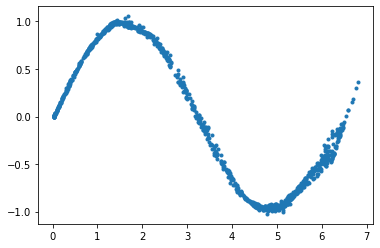

In [59]:
latent_space_samples=torch.randn(1024,2)
generated_samples=generator(latent_space_samples)
generated_samples=generated_samples.detach()
plt.plot(generated_samples[:,0],generated_samples[:,1],'.')

In [60]:
from sklearn.metrics import mean_squared_error
mean_squared_error(generated_samples,training_data)

4.1578307

# Keras package

In [4]:
training_window=20
forward_window=1
x=[]
y=[]
counter=0
for i in range(0,hist.shape[0]-forward_window-training_window+1):
    x.append(np.array(hist.iloc[i:(i+training_window),0]))
    y.append(np.array(hist.iloc[(i+training_window):(i+training_window+forward_window),0]))

x_train=np.array(x[:4000])
y_train=np.array(y[:4000])
x_test=np.array(x[4000:])
y_test=np.array(y[4000:])
x_train=x_train.reshape((x_train.shape[0],1,20,1))
x_test=x_test.reshape((x_test.shape[0],1,20,1))

In [5]:
from keras.layers import LSTM
from keras.layers import Dense, Input,Reshape
from keras.models import Sequential,Model
from keras.layers import Dropout,Activation
import tensorflow as tf
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam

generator_model = Sequential()
generator_model.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal())
                          , input_shape=(None, 20, 1)))
generator_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
generator_model.add(TimeDistributed(Flatten()))
generator_model.add(LSTM(100, activation='relu'))
generator_model.add(Dense(1,activation='linear'))
generator_model.add(Reshape((1,1),input_shape=(1,)))


In [6]:
discriminator_model=Sequential()
discriminator_model.add(Conv1D(filters=32, kernel_size=1, activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal(),input_shape=(1,1)))
discriminator_model.add(MaxPooling1D(pool_size=1))
discriminator_model.add(Dense(1,activation='sigmoid'))
discriminator_model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
def get_cross_entropy():
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy=get_cross_entropy()

def get_d_optimizer(lr):
    return tf.keras.optimizers.Adam(lr=lr)
def get_g_optimizer(lr):
    return tf.keras.optimizers.Adam(lr=lr)
d_optimizer=get_d_optimizer(0.0001)
g_optimizer=get_g_optimizer(0.0001)

In [8]:
def generate_real_samples(data,batch):
    ix=np.random.randint(0,data.shape[0],batch)
    return data[ix].reshape(batch,1,1),np.ones(batch).reshape(batch,1)
def generate_fake_samples(dim):
    return np.random.rand(dim,1,1),np.zeros(dim)

In [9]:
def generate_latent_point(n,dim):
    return np.random.rand(n,1,dim,1),np.zeros(n).reshape(n,1)
def generate_fake_input(n,dim,generator):
    x_input,_=generate_latent_point(n,dim)
    x_output=generator.predict(x_input)
    y=np.zeros((n,1))
    return x_output,y
#x,y=generate_fake_input(100,20,generator_model)

In [10]:
def training(dim,epochs,batch):
    for _ in range(epochs):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            real_points,real_labels=generate_real_samples(y_train,batch)
            random_points,fake_labels=generate_latent_point(batch,dim)
            generated_points=generator_model(random_points)
            prediction=discriminator_model(np.vstack((generated_points,real_points)))
            labels=np.vstack((fake_labels,real_labels))
            labels=labels.reshape(labels.shape[0],1,1)
            d_loss=cross_entropy(prediction,labels)
            d_grads=disc_tape.gradient(d_loss,discriminator_model.trainable_weights)
            d_optimizer.apply_gradients(zip(d_grads,discriminator_model.trainable_weights))
            
            random_points,fake_labels=generate_latent_point(batch,dim)
            misleading_labels=np.ones(batch).reshape(batch,1,1)
            
            fake_points=generator_model(random_points)
            predictions=discriminator_model(fake_points)
            g_loss=cross_entropy(misleading_labels,predictions)
            g_grads=gen_tape.gradient(g_loss,generator_model.trainable_weights)
            g_optimizer.apply_gradients(zip(g_grads,generator_model.trainable_weights))
            
training(20,100,128)

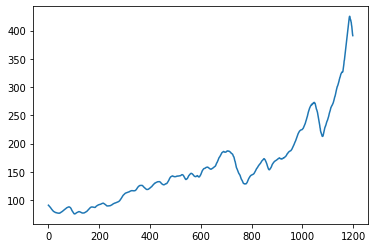

In [11]:
plt.plot(np.negative(generator_model.predict(x_test).flatten()))

In [14]:
generator_model(x_test)

<tf.Tensor: shape=(1199, 1, 1), dtype=float32, numpy=
array([[[ -90.89488]],

       [[ -90.33203]],

       [[ -89.83361]],

       ...,

       [[-398.99426]],

       [[-393.67392]],

       [[-390.93958]]], dtype=float32)>

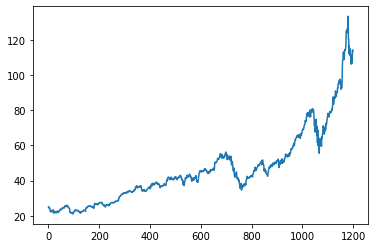

In [12]:
plt.plot(y_test)

Archive

In [64]:
def train_discriminator(model,dataset,epochs,batch):
    for i in range(epochs):
        x_real,y_real=generate_real_samples(dataset,int(batch/2))
        model.train_on_batch(x_real,y_real)
        x_fake,y_fake=generate_fake_samples(int(batch/2))
        model.train_on_batch(x_fake,y_fake)
    return model
discriminator_model=train_discriminator(discriminator_model,y_train,100,128)

In [65]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt)
    return model

def train_gan(dim,epochs,batch):
    gan_model=define_gan(generator_model,discriminator_model)
    for i in range(epochs):
        x,_=generate_latent_point(batch,dim)
        y=np.ones((batch,1))
        gan_model.train_on_batch(x,y)
    return gan_model

In [66]:
def train(g_model,d_model,dataset,dim=20,epochs=100,batch=128):
    gan_model=train_gan(dim,epochs,batch)
    for i in range(epochs):
        x_real,y_real=generate_real_samples(dataset,batch)
        x_fake,y_fake=generate_fake_input(batch,dim,g_model)
        X,Y=np.vstack((x_real,x_fake)),np.vstack((y_real,y_fake))
        d_loss,_=d_model.train_on_batch(X,Y)
        x_gan,y_gan=generate_latent_point(batch,dim)
        #y_gan=np.ones((batch,1))
        g_loss=gan_model.train_on_batch(x_gan,y_gan)
    return gan_model

In [67]:
gan_model=train(generator_model,discriminator_model,y_train,20,100,128)

In [39]:
latent_points,_=generate_latent_point(1195,20)